In [ ]:
pwd

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES']='2'

In [3]:
!free -g

In [4]:
!nvidia-smi

Mon Dec 13 12:06:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 450.51.05    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:18:00.0 Off |                    0 |
| N/A   35C    P0    44W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   

In [5]:
import os
from datetime import datetime; now = datetime.now

analysis_name = 'CVAE_'+str(now())
save_dir = os.path.join('../Assets/tf_weights',analysis_name)
if not os.path.exists(save_dir):
    os.mkdir(save_dir)
    
print(analysis_name)

CVAE_2021-12-13 12:06:00.674481


In [6]:
# CHECK GPU
import nvidia_smi
try:
    nvidia_smi.nvmlInit()

    handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
    # card id 0 hardcoded here, there is also a call to get all available card ids, so we could iterate

    info = nvidia_smi.nvmlDeviceGetMemoryInfo(handle)

    print("Total memory:", (info.total/1024/1024/1024))
    print("Free memory:", (info.free/1024/1024/1024))
    print("Used memory:", (info.used/1024/1024/1024))

    nvidia_smi.nvmlShutdown()
except:
    pass

Total memory: 15.78173828125
Free memory: 15.7816162109375
Used memory: 0.0001220703125


In [7]:
## SET UP

In [8]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from functools import partial
from tqdm import tqdm
from umap import UMAP
tqdm = partial(tqdm, position=0, leave=True) 

In [9]:
pwd

'/mmfs1/data/aglinska/BC-fMRI-AE/Notebooks'

In [10]:
df = pd.read_csv('../Data/ABIDE_df3.csv')
df = df.iloc[~pd.isna(df['bids_folder']).values]
df = df.sort_values(by='bids_folder')
print(len(df))
df.head()

1048


,Unnamed: 0,participant_id,DX_GROUP,DSM_IV_TR,AGE_AT_SCAN,SEX,HANDEDNESS_CATEGORY,HANDEDNESS_SCORES,FIQ,VIQ,...,WISC_IV_DIGIT_SPAN_SCALED,WISC_IV_LET_NUM_SCALED,WISC_IV_CODING_SCALED,WISC_IV_SYM_SCALED,EYE_STATUS_AT_SCAN,AGE_AT_MPRAGE,BMI,bids_folder,site,funcFile
460,460,50642,1,1.0,33.0,1,R,NaN,103.0,98.0,...,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050642,1,CMU_a_0050642_func_preproc.nii.gz
464,464,50646,1,1.0,21.0,1,R,NaN,108.0,100.0,...,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050646,1,CMU_a_0050646_func_preproc.nii.gz
465,465,50647,1,1.0,27.0,1,R,NaN,104.0,97.0,...,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050647,1,CMU_a_0050647_func_preproc.nii.gz
467,467,50649,1,1.0,22.0,1,R,NaN,127.0,121.0,...,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050649,1,CMU_a_0050649_func_preproc.nii.gz
471,471,50653,1,1.0,30.0,1,R,NaN,134.0,131.0,...,NaN,NaN,NaN,NaN,2,NaN,NaN,sub-CMUa0050653,1,CMU_a_0050653_func_preproc.nii.gz


### DATA

In [11]:
data_dir = '../Assets/glasser2016_cmats/filt_noglobal/cmat/'

In [12]:
cmats = np.array([np.load(data_dir+str(val)+'.npy') for val in df['participant_id'].values])
cmats.shape

(1048, 360, 360)

In [13]:
rlbls = pd.read_csv('../Data/GlasserAtlas/glasser360NodeNames.txt',header=None)
rlbls = rlbls[0].to_list()
rlbls = np.array(rlbls)
drop_rois = np.array(['Left_OFC', 'Right_TGv', 'Right_OFC', 'Left_TGv', 'Right_s32',
       'Left_s32', 'Left_pOFC', 'Right_25', 'Left_25', 'Right_LO2',
       'Right_TE1m', 'Right_pOFC', 'Left_10pp', 'Right_PIT', 'Right_13l',
       'Left_LO2', 'Left_PIT', 'Left_7AL', 'Right_PeEc', 'Right_TE2a',
       'Left_TE2a', 'Right_10pp', 'Right_10v', 'Right_47m'])

#drop_rois = drop_rois[0:12]

In [14]:
# Slice ROIs
rslice = np.array([rlbl not in drop_rois for rlbl in rlbls])
print(rslice.sum())

cmats = np.array([cmats[i,:,:][rslice,:][:,rslice] for i in range(cmats.shape[0])])
print(cmats.shape)

336
(1048, 336, 336)


In [15]:
# Drop subjects with NaNs
no_nans = np.isnan(cmats).sum(-1).sum(-1)==0
cmats = cmats[no_nans,:,:]
df = df.iloc[no_nans]

In [16]:
# Normalize to 0-1
cmats = (cmats+1)/2
cmats.shape

(1042, 336, 336)

In [17]:
(cmats.min(),cmats.max())

(0.033334957297894874, 1.0)

In [18]:
%%time
## Reliability data

# Load list of bad ROIs
bad_rois = pd.read_csv('../Data/GlasserAtlas/bad_rois.csv')
bad_rois.head()

# Load Rel data
rel_data = np.load('../Assets/glasser2016_cmats/filt_noglobal/rel-cmats.npz')['rel_cmats']
patients = df['DX_GROUP'].values==1 
rel_asd = rel_data[no_nans,:,:,:]#[patients,:,:,:] #only asd subjects
#rel_asd = rel_data[no_nans,:,:,:][patients,:,:,:] #only asd subjects
del rel_data

rel_rlbls = rlbls.copy() 
v = np.array([rel_rlbl not in bad_rois['rlbl'].values[0:12] for rel_rlbl in rel_rlbls]) #initia slice to 348
rel_rlbls = rel_rlbls[v]

v = np.array([rel_rlbl not in bad_rois['rlbl'].values[0:24] for rel_rlbl in rel_rlbls]) # second slice to 336
rel_rlbls = rel_rlbls[v]

rel_asd = rel_asd[:,v,:,:][:,:,v,:]
rel_asd1 = rel_asd[:,:,:,0] # first half 
rel_asd2 = rel_asd[:,:,:,1] # second half

rel_asd1 = (rel_asd1+1)/2
rel_asd2 = (rel_asd2+1)/2

print(rel_rlbls.shape)

(336,)
CPU times: user 13.8 s, sys: 1.85 s, total: 15.7 s
Wall time: 15.7 s


In [19]:
#np.array([get_triu(rel_asd[s,:,:,0]) for s in range(100)])
#np.array([get_triu(rel_asd[s,:,:,1]) for s in range(100)])
#np.array([get_triu(cmats[s,:,:]) for s in range(100)])

## END OF DATA

In [20]:
%%time
from importlib import reload
import helper_funcs;reload(helper_funcs);from helper_funcs import *
del helper_funcs
import make_models;reload(make_models);from make_models import *
del make_models

from IPython import display
import sys
from sklearn.decomposition import PCA
import seaborn as sns

import tensorflow as tf
reload(tf)

CPU times: user 49.6 ms, sys: 11.6 ms, total: 61.2 ms
Wall time: 257 ms


<module 'tensorflow' from '/data/aglinska/anaconda3/lib/python3.8/site-packages/tensorflow/__init__.py'>

In [21]:
cmats.shape

(1042, 336, 336)

In [22]:
class cvae_data_loader():
    ''' this is the info'''
    def __init__(self,data,df,batch_size=32):
        self.n = len(df)
        self.data = data
        self.epoch = -1
        self.batch_size = batch_size
        self.df = df
        
        self.new_epoch()
        self.n_batches = int(np.floor(min((len(self.asd_idxs),len(self.td_idxs)))/self.batch_size))
        
    def new_epoch(self):
        
        self.asd_idxs = np.nonzero((self.df['DX_GROUP'].values==1))[0]
        self.td_idxs = np.nonzero((self.df['DX_GROUP'].values==2))[0]
        
        self.asd_idxs = np.random.permutation(self.asd_idxs)
        self.td_idxs = np.random.permutation(self.td_idxs)
        
        self.epoch += 1
        self.b = 0
        
    def get_batch(self):
        self.b += 1
        
        if self.b==self.n_batches:
            self.new_epoch()
        
        self.batch_asd_idx = self.asd_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        self.batch_td_idx = self.td_idxs[np.arange(self.b*self.batch_size,self.b*self.batch_size+self.batch_size)]
        
        self.batch_asd = self.data[self.batch_asd_idx,:,:]
        self.batch_td = self.data[self.batch_td_idx,:,:]

#         self.batch_asd = np.array([np.load(os.path.join(self.data_dir,val+'.npy')) for val in self.df['bids_folder'].values[self.batch_asd_idx]])
#         self.batch_td = np.array([np.load(os.path.join(self.data_dir,val+'.npy')) for val in self.df['bids_folder'].values[self.batch_td_idx]])
        
        self.batch_df = self.df.iloc[np.hstack((self.batch_asd_idx,self.batch_td_idx)),:]
        
    
        return self.batch_asd,self.batch_td,self.batch_df

In [23]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [24]:
data_loader = cvae_data_loader(data=cmats, df=df, batch_size=32)
batch_asd,batch_td,batch_df = data_loader.get_batch()

In [25]:
(batch_asd.min(),batch_asd.max())

(0.1494346177111453, 1.0)

In [26]:
data_size = np.hstack((len(df),batch_asd.shape[1:]))
data_size

array([1042,  336,  336])

In [27]:
#patients = df['DX_GROUP'].values==1

In [28]:
# RSA


#cdata = np.array([np.load(os.path.join(data_dir,sub+'.npy')) for sub in df['bids_folder'].values[patients]])
#cdata_pad = pad2d(cdata[:,:,:,np.newaxis]).numpy()[:,:,:,:]

def get_batch_RSA():
    
    patients = ~np.isnan(df['ADOS_TOTAL'].values) * (df['DX_GROUP'].values==1) * ~np.isnan(df['FIQ'].values)
    cdata = cmats[patients,:,:]
    cdata_pad = cdata
    #cdata_pad[patients,:,:]

    Z = z_encoder.predict(cdata_pad)
    S = s_encoder.predict(cdata_pad)

    rdm_z = make_RDM(Z[2])
    rdm_s = make_RDM(S[2])

    rdm_age = make_RDM(df['AGE_AT_SCAN'].values[patients])
    rdm_sex = make_RDM(df['SEX'].values[patients],data_scale='ordinal')
    rdm_fiq = make_RDM(df['FIQ'].values[patients])
    rdm_dsm = make_RDM(df['DSM_IV_TR'].values[patients],data_scale='ordinal')
    rdm_site = make_RDM(df['site'].values[patients],data_scale='ordinal')
    rdm_adosTotal = make_RDM(df['ADOS_TOTAL'].values[patients])
    
    
    batch_rsas_s = dict()
    batch_rsas_z = dict()
    
    
    batch_rsas_s['Site'] = fit_rsa(rdm_s,rdm_site)
    batch_rsas_s['Age'] = fit_rsa(rdm_s,rdm_age)
    batch_rsas_s['Sex'] = fit_rsa(rdm_s,rdm_sex)
    batch_rsas_s['DSM'] = fit_rsa(rdm_s,rdm_dsm)
    batch_rsas_s['ADOS'] = fit_rsa(rdm_s,rdm_adosTotal)
    batch_rsas_s['FIQ'] = fit_rsa(rdm_s,rdm_fiq)

    batch_rsas_z['Site'] = fit_rsa(rdm_z,rdm_site)
    batch_rsas_z['Age'] = fit_rsa(rdm_z,rdm_age)
    batch_rsas_z['Sex'] = fit_rsa(rdm_z,rdm_sex)
    batch_rsas_z['DSM'] = fit_rsa(rdm_z,rdm_dsm)
    batch_rsas_z['ADOS'] = fit_rsa(rdm_z,rdm_adosTotal)
    batch_rsas_z['FIQ'] = fit_rsa(rdm_z,rdm_fiq)
    
    batch_rsas = dict()
    batch_rsas['batch_rsas_z'] = batch_rsas_z
    batch_rsas['batch_rsas_s'] = batch_rsas_s
    
    return batch_rsas

### BV PREDICT

In [29]:
## BV PREDICT
from operator import itemgetter
def slice_df(key,Z,S,init_slice=None):

    nsubs = S.shape[0]
    
    if type(init_slice)==type(None):
        patients = np.repeat(True,nsubs)
    elif type(init_slice)==type(1):
        patients = df['DX_GROUP'].values==init_slice
    elif type(init_slice)==type(np.array(0)) and len(init_slice)==len(df):
        patients = init_slice
    else:
        print(init_slice)
        print(type(init_slice))
        raise BaseException('Weird slice wtf')
    
    X_s = S[patients,:]
    X_z = Z[patients,:]
    
    Y = df[key].values[patients]
    v = ~np.isnan(Y)#[:,0]
    v = v.reshape(-1)

    X_s = X_s[v,:]
    X_z = X_z[v,:]
    Y = Y[v]
    return X_z,X_s,Y


from imblearn.over_sampling import SMOTE,RandomOverSampler
def crossval_resampled(clf,X,Y,cv=5,resample=True):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=cv) #Set up kfold
    y_pred = np.repeat(np.nan,Y.shape) # initiate array 
    
    for train_index, test_index in kf.split(X,Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        
        #print(f'train {y_test.shape[0]} / test {y_test.shape[0]}')
        
        if resample:
            X_train, y_train = oversampler.fit_resample(X_train, y_train)

        y_pred[test_index] = clf.fit(X_train,y_train).predict(X_test)
        #y_pred[test_index] = clf.fit(X_test,y_test).predict(X_test)
        
    # ASSERTS     
    assert np.isnan(y_pred).sum()==0,'nans in prediction'
    
    if resample:
        assert len(np.unique(np.unique(y_train,return_counts=True)[1]))==1,'unbalanced train!'
    
    r2 = r2_score(Y,y_pred)
    
    #return y_pred
    return r2

from sklearn.linear_model import LogisticRegression,LinearRegression,Ridge,ElasticNet,Lasso,SGDRegressor,SGDClassifier
from sklearn.svm import SVC, SVR
from sklearn.neighbors import KNeighborsClassifier as knn, KNeighborsRegressor as knr
oversampler = RandomOverSampler(random_state=42)
#oversampler = SMOTE(k_neighbors=2)
from sklearn.metrics import f1_score,r2_score

# clf = LogisticRegression(penalty='l2',max_iter=1000,C=1)
reg = LinearRegression()

#clf = SVC(C=1,kernel='linear')
#reg = SVR(C=1,kernel='linear')

clf = knn(n_neighbors=5)
#reg = knr(n_neighbors=5)

def bv_predict(Z,S):

    nCV = 50
    bv_Z = dict()
    bv_S = dict()

    key = 'site'
    #use_sites = (np.argsort(np.unique(df['site'].values,return_counts=True)[1])+1)[-1::-1][0:10]
    X_z,X_s,Y = slice_df(key,Z,S,init_slice=patients)
    bv_Z[key] = crossval_resampled(clf, X_z, Y, cv=nCV,resample=False)
    bv_S[key] = crossval_resampled(clf, X_s, Y, cv=nCV,resample=False)

    key = 'AGE_AT_SCAN'
    X_z,X_s,Y = slice_df(key,Z,S,init_slice=patients)
    bv_Z['AGE'] = crossval_resampled(reg, X_z, Y, cv=nCV,resample=False)
    bv_S['AGE'] = crossval_resampled(reg, X_s, Y, cv=nCV,resample=False)

    key = 'SEX'
    X_z,X_s,Y = slice_df(key,Z,S,init_slice=patients)
    bv_Z[key] = crossval_resampled(clf, X_z, Y, cv=nCV,resample=False)
    bv_S[key] = crossval_resampled(clf, X_s, Y, cv=nCV,resample=False)

    key = 'DSM_IV_TR'
    X_z,X_s,Y = slice_df(key,Z,S,init_slice=patients)
    bv_Z['DSM'] = crossval_resampled(clf, X_z, Y, cv=nCV,resample=False)
    bv_S['DSM'] = crossval_resampled(clf, X_s, Y, cv=nCV,resample=False)

    key = 'ADOS_TOTAL'
    X_z,X_s,Y = slice_df(key,Z,S,init_slice=patients)
    bv_Z['ADOS_T'] = crossval_resampled(reg, X_z, Y, cv=nCV,resample=False)
    bv_S['ADOS_T'] = crossval_resampled(reg, X_s, Y, cv=nCV,resample=False)

    key = 'ADOS_SOCIAL'
    X_z,X_s,Y = slice_df(key,Z,S,init_slice=patients)
    bv_Z['ADOS_S'] = crossval_resampled(reg, X_z, Y, cv=nCV,resample=False)
    bv_S['ADOS_S'] = crossval_resampled(reg, X_s, Y, cv=nCV,resample=False)

    key = 'ADOS_STEREO_BEHAV'
    X_z,X_s,Y = slice_df(key,Z,S,init_slice=patients)
    bv_Z['ADOS_R'] = crossval_resampled(reg, X_z, Y, cv=nCV,resample=False)
    bv_S['ADOS_R'] = crossval_resampled(reg, X_s, Y, cv=nCV,resample=False)

    key = 'FIQ'
    X_z,X_s,Y = slice_df(key,Z,S,init_slice=patients)
    bv_Z[key] = crossval_resampled(reg, X_z, Y, cv=nCV,resample=False)
    bv_S[key] = crossval_resampled(reg, X_s, Y, cv=nCV,resample=False)
    
    
    return bv_Z,bv_S

In [30]:
def calc_rel(mat1,mat2):
    
    from scipy.spatial.distance import pdist,squareform

    #mat1 = S_rel1
    #mat2 = S_rel2

    D = squareform(pdist(np.vstack([mat1,mat2])))
    first_second_dist = D[0:mat1.shape[0],:][:,mat1.shape[0]::]

    ranks = []
    for s in range(first_second_dist.shape[0]):
        vec = first_second_dist[s,:]
        within = vec[s]
        across = vec[np.arange(len(vec))!=s]
        rank = (across < within).sum()+1
        ranks.append(rank)

    ranks = np.array(ranks)
    
#     print(np.median(ranks))
#     print((ranks==1).mean())
    
    return ranks

In [31]:
# predictions = cvae.predict([patient_batch,control_batch])
# prediction = predictions[0]
# prediction.shape

In [32]:
#prediction_asd_nopad.shape

In [33]:
def cvae_dashboard():        
    predictions = cvae.predict([patient_batch,control_batch])

    sigma = (np.e ** z_encoder.predict(patient_batch)[1]).mean()
    sigmas.append(sigma)

    mu = z_encoder.predict(patient_batch)[0]
    mus.append(np.mean([mu[:,0].std() for i in range(mu.shape[1])]))

    prediction_asd = predictions[0][:,:,:,0]
    prediction_td = predictions[1][:,:,:,0]

    prediction_asd_nopad = depad_cmat(prediction_asd,tshape=original_size)
    prediction__td_nopad = depad_cmat(prediction_td,tshape=original_size)

    patient_batch_nopad = depad_cmat(patient_batch,tshape=original_size)
    control_batch_nopad = depad_cmat(control_batch,tshape=original_size)


    cmat_actual = np.corrcoef(np.vstack((patient_batch_nopad.reshape(patient_batch_nopad.shape[0],-1),control_batch_nopad.reshape(control_batch_nopad.shape[0],-1))))
    cmat_pred = np.corrcoef(np.vstack((prediction_asd_nopad.reshape(prediction_asd_nopad.shape[0],-1),control_batch_nopad.reshape(control_batch_nopad.shape[0],-1))))
    c_sim.append(np.corrcoef(get_triu(cmat_pred),get_triu(cmat_actual))[0,1])


    ### PROGRESS PLOTTING
    display.clear_output(wait=True);
    display.display(plt.gcf());
    #Organise figure
    ncols = 4;nrows=7
    if np.mod(i,5)==0:
        plt.close()
    plt.subplots(nrows,ncols,figsize=(15,15)); # MAKE THE FIGURE


    ##### SUBPLOT 1 & 2 ##### 

    plt.subplot(nrows,ncols/2,1) # PLOT LOSS
    xs = np.arange(len(loss))+1
    m,b = np.polyfit(xs,loss,deg=1)
    plt.plot(loss)
    plt.plot(xs, m*xs + b)
    plt.title(f'Epoch {data_loader.epoch} batch {data_loader.b}/{data_loader.n_batches} | Loss {loss[-1]:.2f}, beta: {m:.4f}')

    ##### SUBPLOT 3 ##### 
    plt.subplot(nrows,ncols,3) # PLOT LOSS LAST 50
    hb = 50
    if len(loss)>hb:
        plot_loss = loss[-hb::]
        xs = np.arange(len(plot_loss))
        m,b = np.polyfit(xs,plot_loss,deg=1)
        plt.plot(plot_loss)
        plt.plot(xs, m*xs + b)
        #plt.title(hist)
        plt.title(f'Loss last {hb} it, beta {m:.4f}')

    ##### SUBPLOT 4 ##### 
    plt.subplot(nrows,ncols,4)
    plt.hist(prediction_asd_nopad[0,:,:].flatten(),alpha=.5)
    plt.hist(patient_batch_nopad[0,:,:].flatten(),alpha=.5)
    plt.legend(['predicted','actual'])
    plt.title('in/out histograms')

    ##### SUBPLOT 5 ##### 
    plt.subplot(nrows,ncols,5) #RSA over time
    plt.plot(c_sim)
    plt.title(f'in/out RSA: {c_sim[-1].round(2)}')

    if len(c_sim)>5: # PLOT LS LINE
        xs = np.arange(len(c_sim))+1
        m,b = np.polyfit(xs,c_sim,deg=1)
        plt.plot(xs, m*xs + b)
        plt.title(f'in/out RSA: {c_sim[-1].round(2)}, b={m:.4f}')


    ##### SUBPLOT 6 ##### 
    plt.subplot(nrows,ncols,6)
    if len(c_sim)>hb:
        #plot_loss = loss[-hb::]
        xs = np.arange(len(c_sim[-hb::]))
        m,b = np.polyfit(xs,c_sim[-hb::],deg=1)
        plt.plot(c_sim[-hb::])
        plt.plot(xs, m*xs + b)
        #plt.title(hist)
        plt.title(f'in/outRSA last {hb} it, b={m:.4f}')


    batch_rsas = get_batch_RSA()
    batch_rsas_z = batch_rsas['batch_rsas_z']
    batch_rsas_s = batch_rsas['batch_rsas_s']

    # ##### SUBPLOT 7 ##### 
    plt.subplot(nrows,ncols,7)    
    xlbls = list(batch_rsas_z.keys())
    xs = np.arange(len(xlbls))
    ys = np.array([batch_rsas_z[key] for key in xlbls])
    plt.bar(xs,ys)
    plt.xticks(xs,labels=xlbls);
    plt.title('Z RSA')

    # ##### SUBPLOT 8 ##### 
    plt.subplot(nrows,ncols,8)    
    xlbls = list(batch_rsas_s.keys())
    xs = np.arange(len(xlbls))
    ys = np.array([batch_rsas_s[key] for key in xlbls])
    plt.bar(xs,ys)
    plt.xticks(xs,labels=xlbls);
    plt.title('S RSA')

    ##### SUBPLOT 9 ##### 
    plt.subplot(nrows,ncols,9)
    plt.plot(sigmas)
    plt.title(f'sigmas | {sigmas[-1]:.4f}')


    ##### SUBPLOT 10 ##### 
    plt.subplot(nrows,ncols,10)
    plt.plot(mus)
    plt.title(f'Mu variance {mus[-1]:.4f}')


    ##### SUBPLOT 11 ##### 
    plt.subplot(nrows,ncols,11)
    sns.heatmap(cmat_actual,xticklabels=[],yticklabels=[])
    plt.title('input RSA')

    ##### SUBPLOT 12 ##### 
    plt.subplot(nrows,ncols,12)
    sns.heatmap(cmat_pred,xticklabels=[],yticklabels=[])
    plt.title('output RSA')

    # #############################################
    # ###################Reconstructions###########
    # #############################################

    ##### SUBPLOT 13 #####     
    rand_sub = np.random.randint(low=0,high=patient_batch.shape[0])

    plt.subplot(nrows,ncols,13)
    sns.heatmap(patient_batch_nopad[rand_sub,:,:],vmin=0,vmax=1,xticklabels=[],yticklabels=[])
    plt.xticks([]);plt.yticks([]);plt.title('actual');
    ##### SUBPLOT 14 #####     
    plt.subplot(nrows,ncols,14)
    sns.heatmap(prediction_asd_nopad[rand_sub,:,:])
    #sns.heatmap(patient_batch[rand_sub,:,:],vmin=0,vmax=1,xticklabels=[],yticklabels=[])
    plt.xticks([]);plt.yticks([]);plt.title('predicted')
    # ##### SUBPLOT 15 #####     
    plt.subplot(nrows,ncols,15)
    sns.heatmap(abs(patient_batch_nopad[rand_sub,:,:]-prediction_asd_nopad[rand_sub,:,:]))
    plt.xticks([]);plt.yticks([]);plt.title('difference')



    Z = z_encoder.predict(cmats[:,:,:])[2]
    S = z_encoder.predict(cmats[:,:,:])[2]
    bv_Z,bv_S = bv_predict(Z,S)

    ###### SUBPLOT 16 #####                                             
    plt.subplot(nrows,ncols,16)
    xlbls = bv_Z.keys()
    ys = np.array([bv_Z[xlbl] for xlbl in xlbls]);
    ys[ys<-1] = -1
    xs = np.arange(len(ys));
    plt.bar(xs,ys,width=0.5);
    plt.xticks(xs,labels=xlbls,rotation=45);
    plt.title('Z')
    plt.ylabel('R^2')


    # ##### SUBPLOT 20 #####     
    plt.subplot(nrows,ncols,20)
    xlbls = bv_S.keys()
    ys = np.array([bv_S[xlbl] for xlbl in xlbls]);
    ys[ys<-1] = -1
    xs = np.arange(len(ys));
    plt.bar(xs,ys,width=0.5);
    plt.xticks(xs,labels=xlbls,rotation=45);
    plt.title('S')
    plt.ylabel('R^2')


    # ##### SUBPLOT 17 #####                             
    plt.subplot(nrows,ncols,17)
    Z_rel1 = z_encoder.predict(rel_asd1)[2]
    Z_rel2 = z_encoder.predict(rel_asd2)[2]
    z_ranks.append(np.median(calc_rel(Z_rel1,Z_rel2)))
    plt.plot(z_ranks)
    plt.title(f'Z rel\nmed rank = {int(np.median(z_ranks))}, rank1 acc = {(np.array(z_ranks)==1).mean():.4f}')

    # ##### SUBPLOT 18 #####     
    plt.subplot(nrows,ncols,18)
    S_rel1 = s_encoder.predict(rel_asd1)[2]
    S_rel2 = s_encoder.predict(rel_asd2)[2]
    s_ranks.append(np.median(calc_rel(S_rel1,S_rel2)))
    plt.plot(s_ranks)
    plt.title(f'S rel\nmed rank = {int(np.median(s_ranks))}, rank1 acc = {(np.array(s_ranks)==1).mean():.4f}')

    # ##### SUBPLOT 19 ##### 
    plt.subplot(nrows,ncols,19)
    zs_ranks.append(np.median(calc_rel(np.hstack([Z_rel1,S_rel1]),np.hstack([Z_rel2,S_rel2]))))
    plt.plot(zs_ranks)
    plt.title(f'Z+S rel\nmed rank = {int(np.median(zs_ranks))}, rank1 acc = {(np.array(zs_ranks)==1).mean():.4f}')




    # #############################################
    # ################### LOSSES ##################
    # #############################################


    #predictions = cvae.predict([patient_batch,control_batch])
    input_shape = data_size[1:]
    reconstruction_loss = tf.keras.losses.mse(K.flatten(patient_batch), K.flatten(prediction_asd)) 
    reconstruction_loss += tf.keras.losses.mse(K.flatten(control_batch), K.flatten(prediction_td)) 
    #reconstruction_loss *= input_shape[0] * input_shape[1]
    reconstruction_loss *= patient_batch.shape[1] * patient_batch.shape[2]


    tg_z_mean, tg_z_log_var, tg_z = z_encoder.predict(patient_batch)
    tg_s_mean, tg_s_log_var, tg_s = s_encoder.predict(patient_batch)
    bg_z_mean, bg_z_log_var, bg_z = z_encoder.predict(control_batch)

    kl_loss1 = 1 + tg_z_log_var - tf.keras.backend.square(tg_z_mean) - tf.keras.backend.exp(tg_z_log_var)
    kl_loss2 = 1 + tg_s_log_var - tf.keras.backend.square(tg_s_mean) - tf.keras.backend.exp(tg_s_log_var)
    kl_loss3 = 1 + bg_z_log_var - tf.keras.backend.square(bg_z_mean) - tf.keras.backend.exp(bg_z_log_var)

    kl_loss1 = tf.keras.backend.sum(kl_loss1, axis=-1)
    kl_loss2 = tf.keras.backend.sum(kl_loss2, axis=-1)
    kl_loss3 = tf.keras.backend.sum(kl_loss3, axis=-1)
    kl_loss = kl_loss1+kl_loss2+kl_loss3
    kl_loss *= -0.5


    discriminator = Dense(1, activation='sigmoid')
    z1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_z)
    z2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_z)
    s1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_s)
    s2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_s)

    q_bar = tf.keras.layers.concatenate(
      [tf.keras.layers.concatenate([s1, z2], axis=1),
      tf.keras.layers.concatenate([s2, z1], axis=1)],
      axis=0)

    q = tf.keras.layers.concatenate(
      [tf.keras.layers.concatenate([s1, z1], axis=1),
      tf.keras.layers.concatenate([s2, z2], axis=1)],
      axis=0)

    q_bar_score = (discriminator(q_bar)+.1) *.85 # +.1 * .85 so that it's 0<x<1
    q_score = (discriminator(q)+.1) *.85 
    tc_loss = K.log(q_score / (1 - q_score)) 
    discriminator_loss = - K.log(q_score) - K.log(1 - q_bar_score)
    discriminator_loss

    loss_mse.append(reconstruction_loss.numpy())
    loss_kl.append(kl_loss.numpy().mean())
    loss_dc.append(tc_loss.numpy().mean())
    loss_tc.append(discriminator_loss.numpy().mean())


    plt.subplot(nrows,ncols,21) # MSE 
    plt.plot(loss_mse)
    plt.title(f'MSE | {loss_mse[-1]:.4f}')

    plt.subplot(nrows,ncols,22) # KL loss
    plt.plot(loss_kl)
    plt.title(f'KL | {loss_kl[-1]:.4f}')    


    plt.subplot(nrows,ncols,23) # TC     
    plt.plot(loss_tc)
    plt.title(f'Total Correlation loss | {loss_tc[-1]:.4f}')    


    plt.subplot(nrows,ncols,24) # Disc         
    plt.plot(loss_dc)
    plt.title(f'discriminator_loss | {loss_dc[-1]:.4f}')    


    tg_s = s_encoder.predict(patient_batch)
    tg_z = z_encoder.predict(patient_batch)
    bg_z = z_encoder.predict(control_batch)

    plt.subplot(nrows,ncols,25)
    plt.hist(tg_s[2].flatten(),alpha=.5);
    plt.hist(tg_z[2].flatten(),alpha=.5);
    plt.hist(bg_z[2].flatten(),alpha=.5);
    plt.legend(['tg_s','tg_z','bg_z'])
    plt.title('Z')


    plt.subplot(nrows,ncols,26)
    plt.hist(tg_s[0].flatten(),alpha=.5);
    plt.hist(tg_z[0].flatten(),alpha=.5);
    plt.hist(bg_z[0].flatten(),alpha=.5);
    plt.legend(['tg_s','tg_z','bg_z'])
    plt.title('Mus')


    plt.subplot(nrows,ncols,27)
    plt.hist(tg_s[1].flatten(),alpha=.5);
    plt.hist(tg_z[1].flatten(),alpha=.5);
    plt.hist(bg_z[1].flatten(),alpha=.5);
    plt.legend(['tg_s','tg_z','bg_z'])
    plt.title('Sigmas')

    plt.tight_layout()
    plt.show()
    sys.stdout.flush()

In [34]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
import os
import pandas as pd

def get_fMRI_CVAE_3D(input_shape=(51,51,1),
                     latent_dim=[128,128],
                     beta=1,
                     disentangle=False,
                     gamma=1,
                     bias=True,
                     batch_size = 32,
                     kernel_size = 3,
                     filters = 16,
                     filterVec = None,
                     intermediate_dim = 512,
                     nlayers = 2,
                     learning_rate=0.001,
                     strides=2,
                     opt=None):
    
    ndim_bg = latent_dim[0]
    ndim_sl = latent_dim[1]
    
    image_size, _, channels = input_shape

    kernel_regularizer=regularizers.l2(.0001)

    # build encoder model
    tg_inputs = Input(shape=input_shape, name='tg_inputs')
    bg_inputs = Input(shape=input_shape, name='bg_inputs')

    #kernel_initializer = tf.keras.initializers.RandomNormal(mean=0.0,stddev=5)
    kernel_initializer = tf.keras.initializers.RandomUniform()

    # generate latent vector Q(z|X)
    z_h_layer = Dense(intermediate_dim,activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer)
#   z_h_layer = Dense(intermediate_dim, activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer,kernel_initializer=tf.keras.initializers.random_normal(mean=0.0, stddev=5),bias_initializer=tf.keras.initializers.random_normal(mean=0.0, stddev=5))
    z_mean_layer = Dense(ndim_bg, name='z_mean', use_bias=bias,kernel_regularizer=kernel_regularizer)
    z_log_var_layer = Dense(ndim_bg, name='z_log_var', use_bias=bias,kernel_regularizer=kernel_regularizer)
    z_layer = Lambda(sampling, output_shape=(ndim_bg,), name='z')

    def z_encoder_func(inputs):
        z_h = inputs
        #print(filters)
        for i in range(nlayers):
            #filters *= 2
            z_h = Conv2D(filters=filterVec[i],
                    kernel_size=kernel_size,
                    activation='relu',
                    strides=strides,
                    padding='same',
                    use_bias=bias,
                    kernel_regularizer=kernel_regularizer)(z_h)
        
        # shape info needed to build decoder model
        shape = K.int_shape(z_h)
        z_h = Flatten()(z_h)
        z_h = z_h_layer(z_h)
        z_mean =  z_mean_layer(z_h)
        #z_mean = BatchNorm(z_mean)
        
        z_log_var =  z_log_var_layer(z_h)
        z = z_layer([z_mean, z_log_var])
        return z_mean, z_log_var, z, shape

    tg_z_mean, tg_z_log_var, tg_z, shape_z = z_encoder_func(tg_inputs)

    # generate latent vector Q(z|X)
    s_h_layer = Dense(intermediate_dim, activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer)
#    s_h_layer = Dense(intermediate_dim, activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer,kernel_initializer=tf.keras.initializers.random_normal(mean=0.0, stddev=5),bias_initializer=tf.keras.initializers.random_normal(mean=0.0, stddev=5))
    s_mean_layer = Dense(ndim_sl, name='s_mean', use_bias=bias,kernel_regularizer=kernel_regularizer)
    s_log_var_layer = Dense(ndim_sl, name='s_log_var', use_bias=bias,kernel_regularizer=kernel_regularizer)
    s_layer = Lambda(sampling, output_shape=(ndim_sl,), name='s')

    def s_encoder_func(inputs):
        s_h = inputs
        #these_filters = filters
        #print(filters)
        for i in range(nlayers):
            #filters *= 2
            s_h = Conv2D(filters=filterVec[i],
                    kernel_size=kernel_size,
                    activation='relu',
                    strides=strides,
                    use_bias=bias,
                    kernel_regularizer=kernel_regularizer,
                    padding='same')(s_h)
        
        # shape info needed to build decoder model
        shape = K.int_shape(s_h)
        s_h = Flatten()(s_h)
        s_h = s_h_layer(s_h)
        s_mean =  s_mean_layer(s_h)
        #s_mean = BatchNorm(s_mean)
        
        s_log_var =  s_log_var_layer(s_h)        
        s = s_layer([s_mean, s_log_var])
        
        return s_mean, s_log_var, s, shape

    tg_s_mean, tg_s_log_var, tg_s, shape_s = s_encoder_func(tg_inputs)
    bg_z_mean, bg_z_log_var, bg_z, _ = z_encoder_func(bg_inputs) # Aidas and Stefano team hax
    
    
    # instantiate encoder models
    z_encoder = tf.keras.models.Model(tg_inputs, [tg_z_mean, tg_z_log_var, tg_z], name='z_encoder')
    s_encoder = tf.keras.models.Model(tg_inputs, [tg_s_mean, tg_s_log_var, tg_s], name='s_encoder')


    # build decoder model
    latent_inputs = Input(shape=(ndim_bg+ndim_sl,), name='z_sampling')

    x = Dense(intermediate_dim, activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer,kernel_initializer=kernel_initializer)(latent_inputs)
    x = Dense(shape_z[1] * shape_z[2] * shape_z[3], activation='relu', use_bias=bias,kernel_regularizer=kernel_regularizer,kernel_initializer=kernel_initializer)(x)
    x = Reshape((shape_z[1], shape_z[2], shape_z[3]))(x)

    #these_filters = filters*(2**nlayers)/2
    #these_filters = filters
    for i in range(nlayers-1):
        x = Conv2DTranspose(filters=filterVec[-1::-1][i]/2,
                          kernel_size=kernel_size,
                          activation='relu',
                          strides=strides,
                          use_bias=bias,
                          kernel_regularizer=kernel_regularizer,
                          padding='same')(x)
        #filters //= 2
       # if these_filters

    outputs = Conv2DTranspose(filters=channels,
                            kernel_size=kernel_size,
                            activation='sigmoid',
                            padding='same',
                            strides=strides,
                            use_bias=bias,
                            kernel_regularizer=kernel_regularizer,
                            name='decoder_output')(x)

    # instantiate decoder model
    cvae_decoder = Model(latent_inputs, outputs, name='decoder')
      # decoder.summary()

    def zeros_like(x):
        return tf.zeros_like(x)

    tg_outputs = cvae_decoder(tf.keras.layers.concatenate([tg_z, tg_s], -1))
    zeros = tf.keras.layers.Lambda(zeros_like)(tg_s)

    bg_outputs = cvae_decoder(tf.keras.layers.concatenate([bg_z, zeros], -1)) # Aidas look into this, is this correct

    cvae = tf.keras.models.Model(inputs=[tg_inputs, bg_inputs], 
                                  outputs=[tg_outputs, bg_outputs],
                                  name='contrastive_vae')

#     cvae_fg = tf.keras.models.Model(inputs=tg_inputs, 
#                                   outputs=fg_outputs, 
#                                   name='contrastive_vae_fg')

    if disentangle:
        discriminator = Dense(1, activation='sigmoid')

        z1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_z)
        z2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_z)
        s1 = Lambda(lambda x: x[:int(batch_size/2),:])(tg_s)
        s2 = Lambda(lambda x: x[int(batch_size/2):,:])(tg_s)

        q_bar = tf.keras.layers.concatenate(
          [tf.keras.layers.concatenate([s1, z2], axis=1),
          tf.keras.layers.concatenate([s2, z1], axis=1)],
          axis=0)

        q = tf.keras.layers.concatenate(
          [tf.keras.layers.concatenate([s1, z1], axis=1),
          tf.keras.layers.concatenate([s2, z2], axis=1)],
          axis=0)

        q_bar_score = (discriminator(q_bar)+.1) *.85 # +.1 * .85 so that it's 0<x<1
        q_score = (discriminator(q)+.1) *.85 
        tc_loss = K.log(q_score / (1 - q_score)) 
        discriminator_loss = - K.log(q_score) - K.log(1 - q_bar_score)
    else:
        tc_loss = 0
        discriminator_loss = 0


    reconstruction_loss = tf.keras.losses.mse(K.flatten(tg_inputs), K.flatten(tg_outputs)) 
    reconstruction_loss += tf.keras.losses.mse(K.flatten(bg_inputs), K.flatten(bg_outputs)) 
    reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]

    kl_loss1 = 1 + tg_z_log_var - tf.keras.backend.square(tg_z_mean) - tf.keras.backend.exp(tg_z_log_var)
    kl_loss2 = 1 + tg_s_log_var - tf.keras.backend.square(tg_s_mean) - tf.keras.backend.exp(tg_s_log_var)
    kl_loss3 = 1 + bg_z_log_var - tf.keras.backend.square(bg_z_mean) - tf.keras.backend.exp(bg_z_log_var)

    kl_loss1 = tf.keras.backend.sum(kl_loss1, axis=-1)
    kl_loss2 = tf.keras.backend.sum(kl_loss2, axis=-1)
    kl_loss3 = tf.keras.backend.sum(kl_loss3, axis=-1)

    kl_loss = kl_loss1+kl_loss2+kl_loss3
    #kl_loss = tf.keras.backend.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    
    cvae_loss = tf.keras.backend.mean(reconstruction_loss + beta*kl_loss + gamma*tc_loss + discriminator_loss)
    cvae.add_loss(cvae_loss)
    
    if type(opt)==type(None):
        #print('optimizer not specified using ADAM, wroom wroom')
        opt = tf.keras.optimizers.Adam(learning_rate=learning_rate,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False,name='Adam')
        #opt = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.9, epsilon=1e-07, centered=False, name='RMSprop')
        #opt = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.1, nesterov=False, name='SGD')


    cvae.compile(optimizer=opt,run_eagerly=True)
    
    return cvae, z_encoder, s_encoder, cvae_decoder

In [35]:
print(data_size)

[1042  336  336]


In [36]:
original_size = data_size[1]
original_size

336

In [37]:
# PADDING
def pad_to_target(cmats,tshape=512):
    cshape = cmats.shape[1::][0]
    #tshape=486    
    d = abs(cshape-tshape)
    if np.mod(d,2)==0:
        pa = (int(np.floor(d/2)),int(np.floor(d/2)))
    else:
        pa = (int(np.floor(d/2)),int(np.floor(d/2))+1)

    pad2d = tf.keras.layers.ZeroPadding2D(padding=(pa,pa)) #If tuple of 2 tuples of 2 ints: interpreted as ((top_pad, bottom_pad), (left_pad, right_pad))
    
    return np.array(pad2d(np.array(cmats[:,:,:,np.newaxis]).astype(np.float32)))

In [38]:
def depad_cmat(inMat,tshape=348):
    cshape = inMat.shape[1]
    if cshape>tshape:
        d = abs(tshape-cshape)
        if np.mod(d,2)==0:
            pa = (int(np.floor(d/2)),int(np.floor(d/2)))
        else:
            pa = (int(np.floor(d/2)),int(np.floor(d/2))+1)
        depadded = inMat[:,pa[0]:-pa[1]:1,pa[0]:-pa[1]:1]
    else:
        depadded=inMat
        
    return depadded

In [39]:
batch_size = 32
cvae, z_encoder, s_encoder, cvae_decoder = get_fMRI_CVAE_3D(input_shape=(384,384,1),
                                                             latent_dim=[64,64],
                                                             beta=1e-6,
                                                             gamma=1,
                                                             disentangle=True,
                                                             bias=True,
                                                             batch_size = batch_size,
                                                             kernel_size = 2,
                                                             filters = None,
                                                             filterVec = np.array([2,4,8,16,32,64,128,256,512]),
                                                             intermediate_dim = 128,
                                                             nlayers = 7,
                                                             strides= 2,
                                                             learning_rate=0.001,
                                                             opt=None)

num_params = np.sum([np.prod(val.get_shape()) for val in cvae.trainable_weights])
print(f'# params| {num_params:,}')

num_weights = [np.prod(cvae.trainable_weights[i].get_shape()) for i in range(len(cvae.trainable_weights))]
idxs = np.argsort(num_weights)[-1::-1]
for i in range(1):
    print(f'largest layer: {cvae.trainable_weights[idxs[i]].name} | # {num_weights[idxs[i]]:,}')
    
print(f'I shape: {cvae.input_shape[0]}')
print(f'O shape: {cvae.output_shape[0]}')

# params| 931,468
largest layer: dense_1/kernel:0 | # 147,456
I shape: (None, 384, 384, 1)
O shape: (None, 384, 384, 1)


In [40]:
target_size = cvae.output_shape[0][1]
target_size

384

In [41]:
#target_size = 336
if cmats.shape[1]<target_size:
    cmats = pad_to_target(cmats,tshape=target_size)[:,:,:,0]
    rel_asd1 = pad_to_target(rel_asd1,tshape=target_size)[:,:,:,0]
    rel_asd2 = pad_to_target(rel_asd2,tshape=target_size)[:,:,:,0]

print(cmats.shape)
print(rel_asd1.shape)

(1042, 384, 384)
(1042, 384, 384)


In [42]:
z_encoder.summary(line_length=150)

Model: "z_encoder"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
tg_inputs (InputLayer)                           [(None, 384, 384, 1)]            0                                                                   
______________________________________________________________________________________________________________________________________________________
conv2d (Conv2D)                                  (None, 192, 192, 2)              10                tg_inputs[0][0]                                   
______________________________________________________________________________________________________________________________________________________
conv2d_1 (Conv2D)                                (None, 96, 96, 4)         

In [43]:
cvae_decoder.summary(line_length=150)

Model: "decoder"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                                       Output Shape                                                Param #                
z_sampling (InputLayer)                                            [(None, 128)]                                               0                      
______________________________________________________________________________________________________________________________________________________
dense_2 (Dense)                                                    (None, 128)                                                 16512                  
______________________________________________________________________________________________________________________________________________________
dense_3 (Dense)                                                    (None, 115

In [44]:
s_encoder.summary(line_length=150)

Model: "s_encoder"
______________________________________________________________________________________________________________________________________________________
Layer (type)                                     Output Shape                     Param #           Connected to                                      
tg_inputs (InputLayer)                           [(None, 384, 384, 1)]            0                                                                   
______________________________________________________________________________________________________________________________________________________
conv2d_7 (Conv2D)                                (None, 192, 192, 2)              10                tg_inputs[0][0]                                   
______________________________________________________________________________________________________________________________________________________
conv2d_8 (Conv2D)                                (None, 96, 96, 4)         

In [45]:
# Initialize arrays
loss,all_rsas,sigmas,mus,c_sim = [],[],[],[],[]
loss_mse,loss_kl,loss_dc,loss_tc = [],[],[],[]
s_ranks,z_ranks,zs_ranks = [],[],[]

In [46]:
data_loader = cvae_data_loader(data=cmats, df=df, batch_size=32)

<Figure size 432x288 with 0 Axes>

<ipython-input-33-08ab1a5f4b0d>:37: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrows,ncols/2,1) # PLOT LOSS


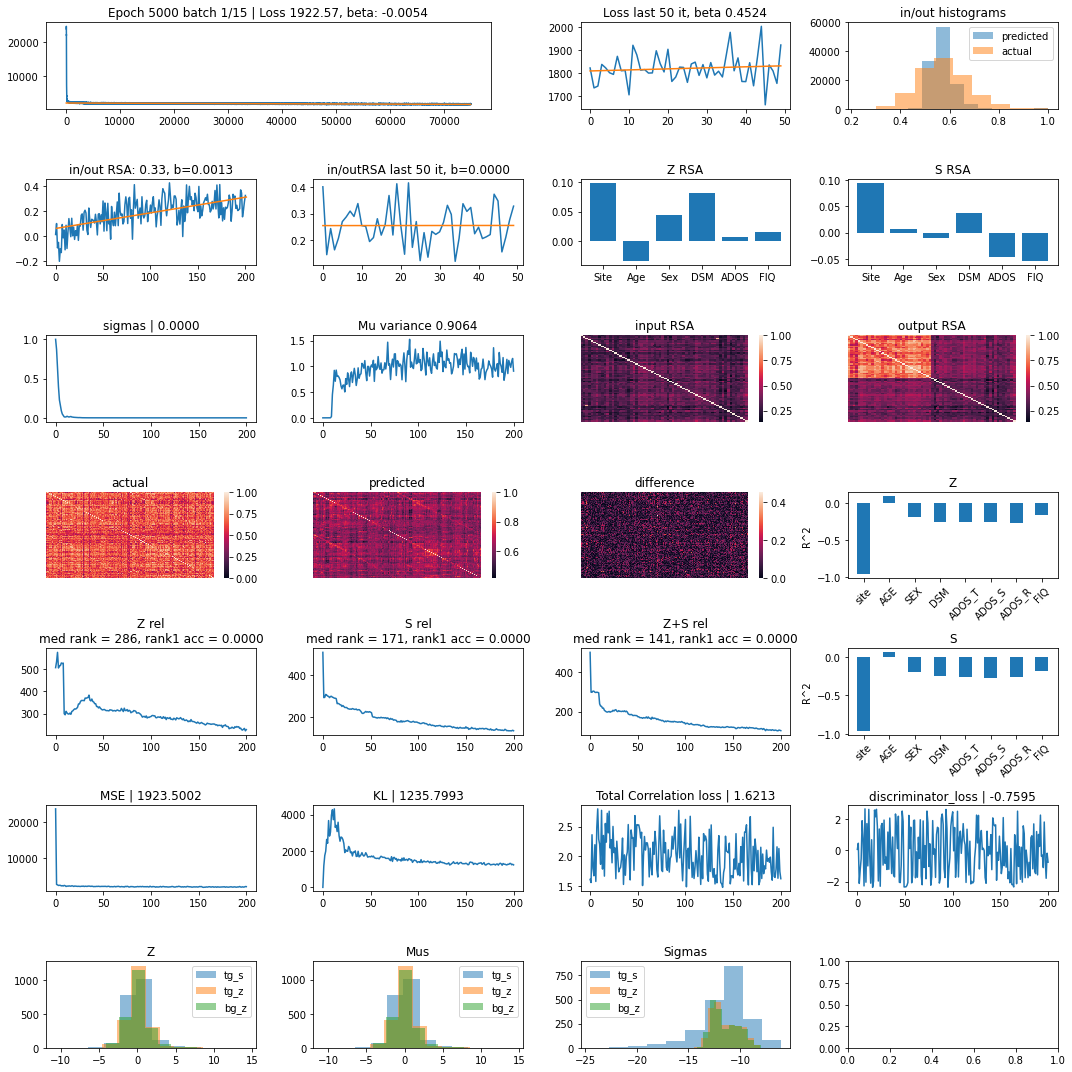

In [ ]:
for epoch in tqdm(range(5001)):
    for i in range(data_loader.n_batches):
        
        patient_batch,control_batch,batch_df = data_loader.get_batch() # Get a batch
        
        hist = cvae.train_on_batch([patient_batch,control_batch]) # pass a batch
        assert not np.isnan(hist),'loss is NaN - you f**cked up'  # check nothing crashed
        loss.append(hist) # keep track of loss
        
        #patient_batch = depad_cmat(patient_batch,tshape=348)
        #control_batch = depad_cmat(control_batch,tshape=348)
        
        if all((i==0,np.mod(epoch,25)==0)):
            cvae_dashboard() # plot training progress
            cvae.save_weights(os.path.join(save_dir,'cvae_weights')) # SAVE WEIGHTS
            np.save(os.path.join(save_dir,'cvae_loss.npy'),np.array(loss)) # Save loss
            #plt.show()

In [ ]:
cvae.summary()